**1. Exploratory data analysis**

In [1]:
#Import Tools for project
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/content/creditcard.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**Handling Missing Values**

In [4]:
df.isnull().values.any()

False

In [5]:
df.dropna()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


**Outlier Treatment**

Outlier treatment is unecessary for this dataset, since the raw dataset is already PCA transformed. Therefore, we can assume that the outlier values are already taken care of during the transformation.

From the raw dataset, Time is given as a timestamp. There the value is convert to local data and extract the hours in the attempt to identify if if the hour of the transaction is correlated with the likelability that the transaction is fraudulent

In [6]:
from datetime import datetime
df["Hour"] = df["Time"].apply(datetime.fromtimestamp).dt.hour

**Remove duplicates**

In [7]:
df.shape

(284807, 32)

In [8]:
duplicateRowsDf = df[df.duplicated()]
df.drop_duplicates(inplace= True)
df.shape

(283726, 32)

There was a total of 1081 duplication transaction in the data set

In [9]:
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import  PolynomialFeatures, KBinsDiscretizer, FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, OrdinalEncoder
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, export
from sklearn.ensemble import BaggingClassifier, BaggingRegressor,RandomForestClassifier,RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor 
from sklearn.svm import LinearSVC, LinearSVR, SVC, SVR
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import QuantileTransformer

# **Train-Test Split**

Before attempting Feature Engineering, we need to create another set to prevent it from leaking our information to the test set. 
Training Size will be 70% and Testing Size will be 30%

In [10]:
train,test = train_test_split(df, test_size=0.3, random_state=20, stratify=df[["Class"]])
tr_value_counts = train["Class"].value_counts()

print("Fraudulent transactions are %.2f%% of the training set." % (tr_value_counts[1] * 100 / len(train)))


tst_value_counts = test["Class"].value_counts()

print("Fraudulent transactions are %.2f%% of the test set." % (tst_value_counts[1] * 100 / len(test)))



Fraudulent transactions are 0.17% of the training set.
Fraudulent transactions are 0.17% of the test set.


Time column will be dropped since hour will be used for the modeling

In [11]:
train = train.drop(["Time"], axis=1)
test = test.drop(["Time"], axis=1)

In [12]:
X_train = train.iloc[:, train.columns != "Class"]

y_train = train.iloc[:, train.columns == "Class"]

X_test = test.iloc[:, test.columns != "Class"]

y_test = test.iloc[:, test.columns == "Class"]

In [13]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Hour
260077,2.165551,-0.931977,-0.825217,-0.976348,-0.806100,-0.482170,-0.869593,-0.055487,-0.256162,0.927807,0.543879,0.031113,0.013013,-0.149598,-0.635406,1.315547,-0.169662,-0.760603,1.011890,-0.027782,0.225936,0.686494,0.116975,-0.386258,-0.122954,-0.174076,-0.008978,-0.066268,11.00,20
171490,-0.263757,0.333658,1.320915,-0.728436,0.211890,0.026035,0.432156,-0.197118,0.860935,-0.550587,-1.745319,-0.380098,0.015777,-0.536872,0.476001,-0.011856,-0.728361,0.631569,0.541292,0.015915,0.241983,1.030178,-0.374859,-0.657589,-0.293335,0.216249,-0.116099,-0.043637,22.72,9
143414,1.394940,-0.725507,0.513857,-0.737259,-1.243254,-0.672043,-0.872506,0.004601,-0.285987,0.653846,-1.004247,-1.772010,-1.641884,0.088128,1.195414,1.595815,0.081561,-0.927929,0.673075,-0.001526,-0.002746,-0.235306,0.026229,-0.176055,0.246006,-0.330504,0.006173,0.018870,25.48,23
203966,1.839303,-0.658990,-1.318029,0.271534,1.650956,4.230737,-1.334916,1.159807,1.013593,0.144832,-0.219967,0.409759,0.038813,-0.025584,1.058441,0.495287,-0.858105,0.139520,-0.806055,-0.087474,0.074062,0.180545,0.282958,0.660041,-0.314983,-0.738293,0.090650,-0.019662,45.00,13
159774,-0.602259,0.471985,1.262224,-0.466357,0.021201,0.267186,0.245404,0.088205,0.400334,-0.455876,0.153216,0.695694,0.292072,-0.209733,-0.329608,0.147359,-0.850055,1.087295,0.618337,-0.083601,0.387928,1.238425,-0.328957,-0.441262,-0.255920,-0.139216,-0.065400,0.209145,39.95,7


**Feature Scaling**

Since most of the data has already been scaled through PCA. The only attribute left to normalize is Amount.

In [14]:
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
X_train['Amount'] = robust_scaler.fit_transform(X_train[['Amount']])
X_train['Hour'] = robust_scaler.fit_transform(X_train[['Hour']])

In [15]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Hour
260077,2.165551,-0.931977,-0.825217,-0.976348,-0.806100,-0.482170,-0.869593,-0.055487,-0.256162,0.927807,0.543879,0.031113,0.013013,-0.149598,-0.635406,1.315547,-0.169662,-0.760603,1.011890,-0.027782,0.225936,0.686494,0.116975,-0.386258,-0.122954,-0.174076,-0.008978,-0.066268,-0.152985,0.555556
171490,-0.263757,0.333658,1.320915,-0.728436,0.211890,0.026035,0.432156,-0.197118,0.860935,-0.550587,-1.745319,-0.380098,0.015777,-0.536872,0.476001,-0.011856,-0.728361,0.631569,0.541292,0.015915,0.241983,1.030178,-0.374859,-0.657589,-0.293335,0.216249,-0.116099,-0.043637,0.010014,-0.666667
143414,1.394940,-0.725507,0.513857,-0.737259,-1.243254,-0.672043,-0.872506,0.004601,-0.285987,0.653846,-1.004247,-1.772010,-1.641884,0.088128,1.195414,1.595815,0.081561,-0.927929,0.673075,-0.001526,-0.002746,-0.235306,0.026229,-0.176055,0.246006,-0.330504,0.006173,0.018870,0.048399,0.888889
203966,1.839303,-0.658990,-1.318029,0.271534,1.650956,4.230737,-1.334916,1.159807,1.013593,0.144832,-0.219967,0.409759,0.038813,-0.025584,1.058441,0.495287,-0.858105,0.139520,-0.806055,-0.087474,0.074062,0.180545,0.282958,0.660041,-0.314983,-0.738293,0.090650,-0.019662,0.319878,-0.222222
159774,-0.602259,0.471985,1.262224,-0.466357,0.021201,0.267186,0.245404,0.088205,0.400334,-0.455876,0.153216,0.695694,0.292072,-0.209733,-0.329608,0.147359,-0.850055,1.087295,0.618337,-0.083601,0.387928,1.238425,-0.328957,-0.441262,-0.255920,-0.139216,-0.065400,0.209145,0.249644,-0.888889


*Scaling the test set*

In [16]:
robust_scaler = RobustScaler()
X_test['Amount'] = robust_scaler.fit_transform(X_test[['Amount']])
X_test['Hour'] = robust_scaler.fit_transform(X_test[['Hour']])
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Hour
77498,1.044612,0.050072,0.347682,1.437991,-0.157549,-0.143992,0.189803,-0.063823,0.196898,-0.170576,-0.437990,0.836499,0.452189,-0.033973,-0.148883,-0.741747,0.232751,-1.035614,-0.391507,-0.026473,-0.057416,-0.042475,-0.123837,0.113735,0.659664,-0.321384,0.031825,0.028138,0.677097,0.000000
9568,-0.939118,3.126938,-2.255336,1.771850,0.545432,-1.387188,-0.327357,-3.439817,1.297149,-0.796065,2.127740,-2.030422,2.641924,-2.258201,0.134531,0.669302,3.897365,1.557782,-0.830831,-0.483266,2.783637,-1.231198,0.664470,0.273981,-0.367874,-0.484481,-0.076905,-0.174300,-0.293138,-1.333333
161591,1.844826,0.181078,-0.300584,3.836047,0.210215,0.965983,-0.419067,0.342796,-0.358031,1.478006,-0.134069,0.100098,-1.295026,0.078065,-2.447515,0.582341,-0.534397,0.090683,-1.037965,-0.359764,0.124608,0.528761,0.126287,0.681011,0.037316,0.088008,-0.015504,-0.052698,-0.284535,-0.888889
7667,-0.636393,0.820481,2.560305,1.091706,-0.169117,0.350480,0.087370,-0.046477,1.893215,-0.352846,-0.383537,-2.987590,1.076185,0.840979,-0.226339,-0.255486,0.504406,0.671811,0.619927,0.128289,-0.262144,-0.053601,-0.189245,-0.195063,0.009735,-0.354480,0.099431,-0.062962,-0.236245,-1.444444
258332,2.135169,0.039689,-1.745516,0.083085,0.641935,-0.529757,0.244653,-0.315274,0.499787,-0.016461,-1.187295,0.490051,1.081555,0.257164,0.740001,-0.026745,-0.830636,0.091516,0.037289,-0.137786,0.203099,0.762255,-0.060390,0.144227,0.409868,-0.104480,-0.019673,-0.056889,-0.291612,0.555556


# **Checking the Skewness**

In [17]:
#Looking at the columns for the trainset
cols = X_train.columns
cols

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Hour'],
      dtype='object')

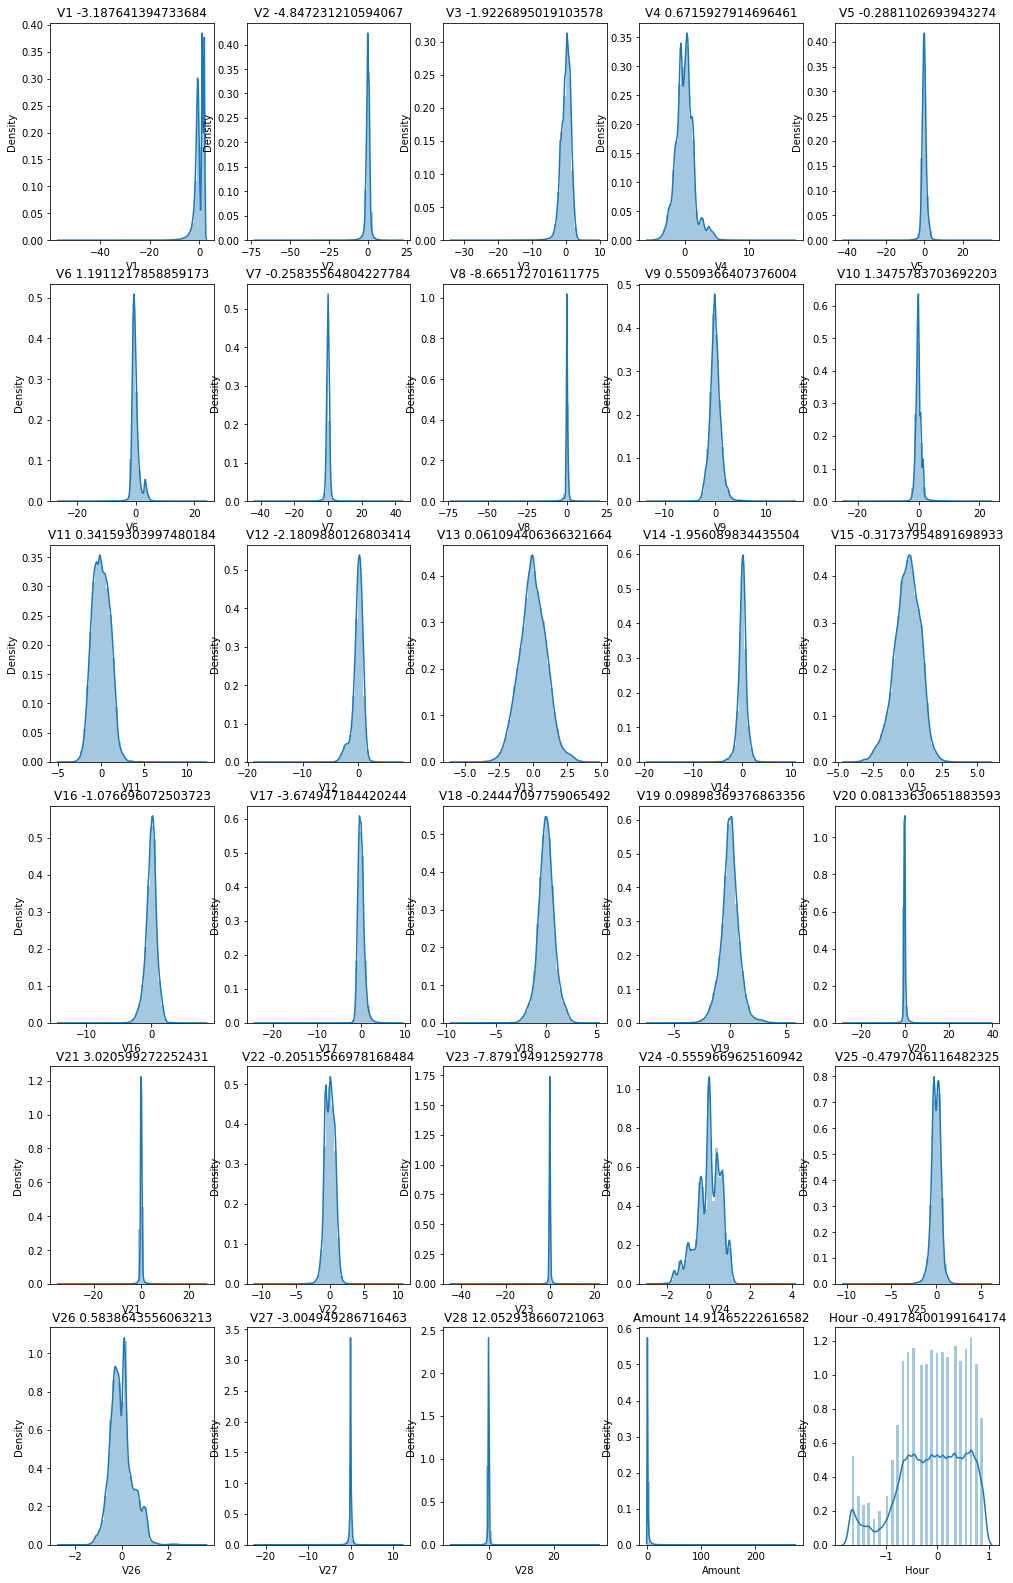

In [18]:
#Plotting a distribution for the variable to determine the skewness of each variable.
k=0
plt.figure(figsize=(17,28))
for col in cols :    
    k=k+1
    plt.subplot(6, 5,k)    
    sns.distplot(X_train[col])
    plt.title(col+' '+str(X_train[col].skew()))

From the graph, we noticed that alot of variables are heavily skewed. Therefore, we will only for particular varibles for a normal distribution

**Mitigate skweness with PowerTransformer**

In [19]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method = 'yeo-johnson', standardize = True, copy = False)
X_train[cols] = pt.fit_transform(X_train)

In [20]:
X_test[cols] = pt.fit_transform(X_test)

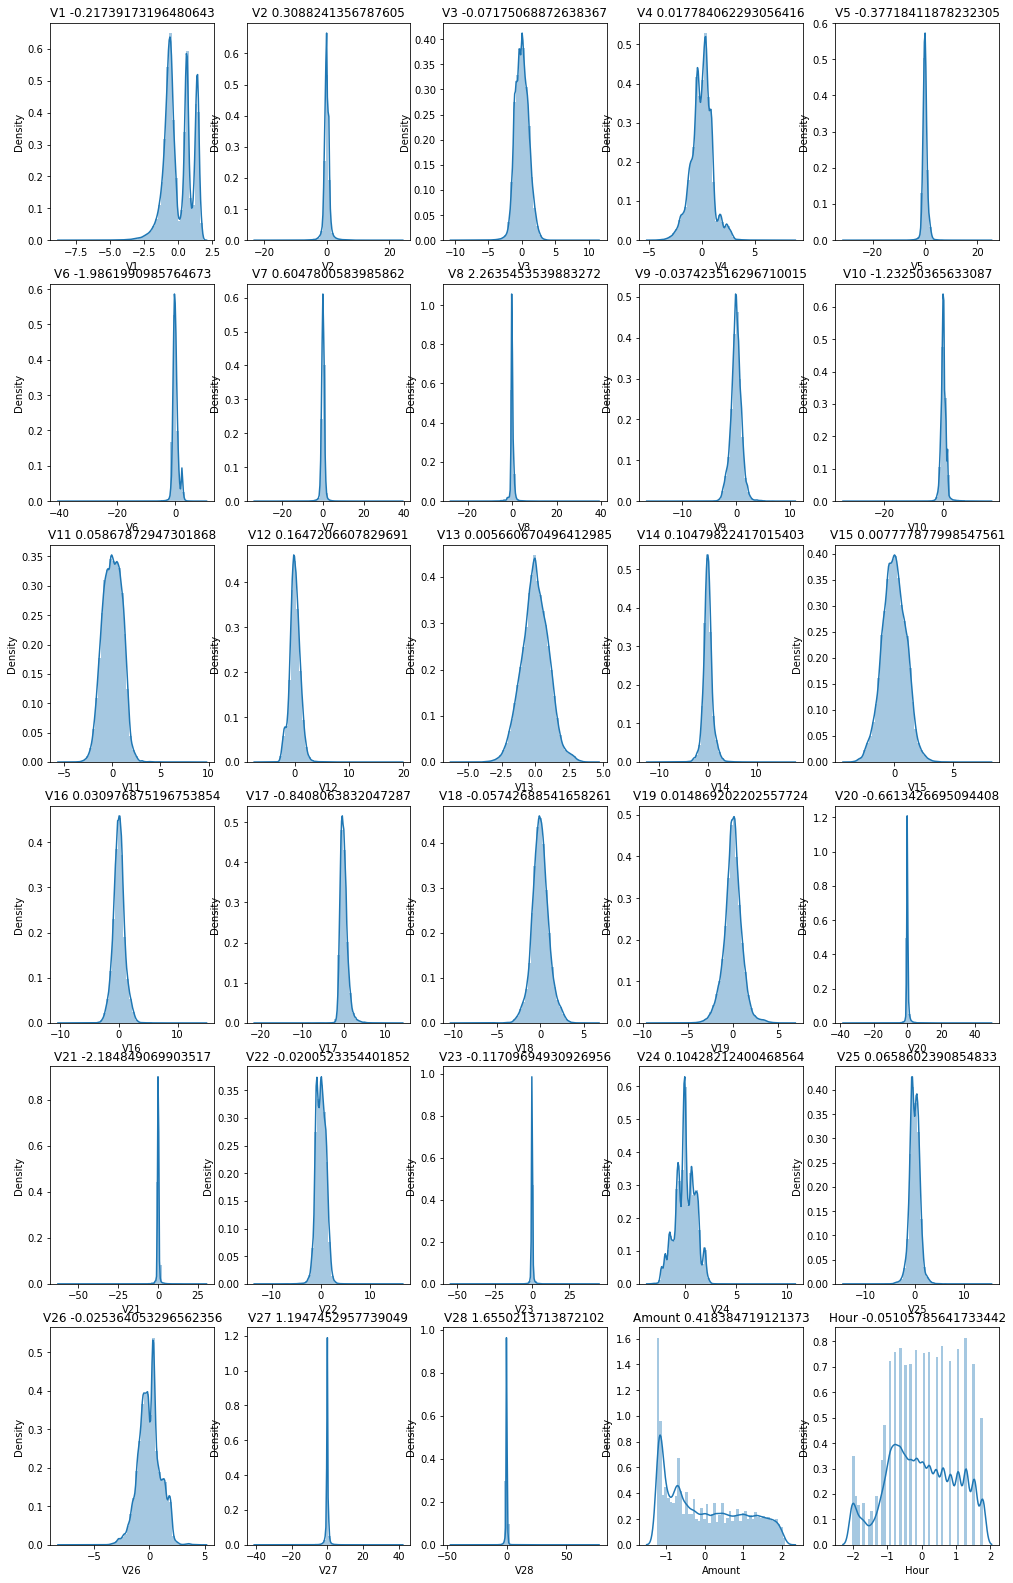

In [21]:
k=0
plt.figure(figsize=(17,28))
for col in cols :    
    k=k+1
    plt.subplot(6, 5,k)    
    sns.distplot(X_train[col])
    plt.title(col+' '+str(X_train[col].skew()))

After the transformation, the variables are more normally distributed and more stablize.

**Oversampling**

In [22]:
#Importing undersampler form library
from imblearn.over_sampling import  RandomOverSampler

In [24]:
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# **Model Building for balanced data with Oversampling**

The cross varlidation strategy for each model will be 5 folds.

In [25]:
#Import Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#Import for cross validation

# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

*Decision Tree*

In [26]:
param_grid1 = {
    'max_depth': range(4,8,12),
    'min_samples_leaf': range(50,150,50),
    'min_samples_split': range(50,150,50),
}

dt = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator= dt, param_grid= param_grid1, scoring= 'roc_auc', cv =5,verbose =1)

In [27]:
grid_search.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(4, 8, 12),
                       

In [28]:
#cv results
cv_result = pd.DataFrame(grid_search.cv_results_)
cv_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.748629,0.107556,0.025401,0.000812,4,50,50,"{'max_depth': 4, 'min_samples_leaf': 50, 'min_...",0.981539,0.980028,0.978770,0.979938,0.978940,0.979843,0.000989,2
1,3.670073,0.083554,0.025634,0.000824,4,50,100,"{'max_depth': 4, 'min_samples_leaf': 50, 'min_...",0.981564,0.980028,0.978770,0.979938,0.978940,0.979848,0.000997,1
2,3.653440,0.045372,0.026747,0.003276,4,100,50,"{'max_depth': 4, 'min_samples_leaf': 100, 'min...",0.981502,0.979987,0.978716,0.979855,0.978859,0.979784,0.000999,3
3,3.482451,0.070069,0.024335,0.000959,4,100,100,"{'max_depth': 4, 'min_samples_leaf': 100, 'min...",0.981502,0.979987,0.978716,0.979855,0.978859,0.979784,0.000999,3


In [29]:
#Printing the optimal sensitivity score and hyperparameters
print('Best roc_auc: -', grid_search.best_score_)
print(grid_search.best_estimator_)

Best roc_auc: - 0.9798481099431834
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [30]:
#Buliding the model with the best hyperparameters
dt_model = DecisionTreeClassifier(criterion= 'gini', random_state= 20, max_depth= 4, min_samples_leaf = 100, min_samples_split= 100 )

dt_model.fit(X_resampled, y_resampled)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=20, splitter='best')

*Prediction on the test set*

In [31]:
#Predict Probability
dt_pred = dt_model.predict(X_test)

In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Classification Report
print(classification_report(y_test,dt_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     84976
           1       0.04      0.89      0.07       142

    accuracy                           0.96     85118
   macro avg       0.52      0.93      0.53     85118
weighted avg       1.00      0.96      0.98     85118



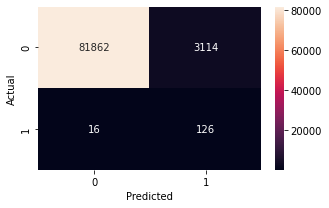

In [33]:
#Confusion Matrix
cm = confusion_matrix(y_test, dt_pred)
cm = pd.DataFrame(cm, columns=np.unique(y_test), index= np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(5,3))
sns.heatmap(cm, fmt = 'g', annot= True)

In [35]:
confusion = metrics.confusion_matrix(y_test, dt_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, dt_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.963227519443596
Sensitivity:- 0.8873239436619719
Specificity:- 0.9633543588778007


In [36]:
from sklearn.model_selection import cross_val_score
#Cross Validare Score
dt_scores = cross_val_score(dt_model, X_resampled, y_resampled, cv = 5)

print("Decision Tree Cross Validate Score:", np.round(dt_scores.mean()*100,3), '%')

Decision Tree Cross Validate Score: 95.581 %


*Plotting ROC*

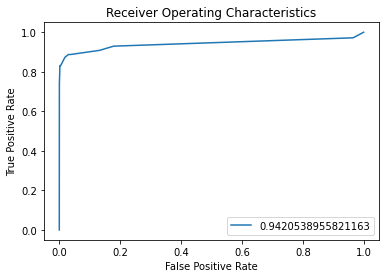

In [37]:
dt_proba = dt_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, dt_proba)
auc = metrics.roc_auc_score(y_test, dt_proba)

plt.title('Receiver Operating Characteristics')
plt.plot(fpr, tpr, label = str(auc))
plt.legend(loc = 4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*Precision-Recall Curve*

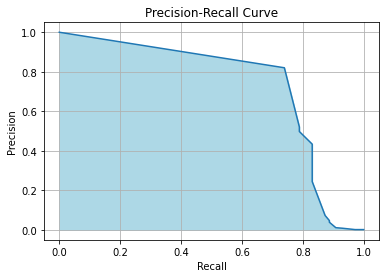

In [38]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, dt_proba)
fig, ax = plt.subplots()
ax.plot(recall, precision)

ax.set_title("Precision-Recall Curve")
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.fill_between(recall, precision, color = 'lightblue')
plt.grid()
plt.show()

*Logisitic Regression*

In [39]:
from sklearn.linear_model import LogisticRegression

#Creating KFold object with 5 split
folds = KFold(n_splits=5, shuffle = True, random_state = 20)

#Specify params
params3 = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_log = GridSearchCV(estimator = LogisticRegression(),
                         param_grid = params3,
                         scoring = 'roc_auc',
                         cv = folds,
                         verbose = 1,
                         return_train_score = True)
#Fit the model
model_log.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.2min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=20, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=1)

In [40]:
#Logisitics Regression results
log_results = pd.DataFrame(model_log.cv_results_)
log_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.149975,0.072794,0.033887,0.000336,0.01,{'C': 0.01},0.986112,0.986674,0.986492,0.986528,0.986088,0.986379,0.000236,6,0.986474,0.986357,0.986313,0.986379,0.986465,0.986398,0.000063
1,2.234963,0.053596,0.035192,0.004414,0.1,{'C': 0.1},0.986194,0.986751,0.986550,0.986579,0.986158,0.986446,0.000231,5,0.986537,0.986425,0.986378,0.986449,0.986529,0.986463,0.000061
2,2.191851,0.083750,0.033909,0.001550,1,{'C': 1},0.986203,0.986756,0.986553,0.986583,0.986166,0.986452,0.000230,4,0.986543,0.986434,0.986384,0.986455,0.986534,0.986470,0.000061
3,2.251852,0.051178,0.033518,0.000810,10,{'C': 10},0.986203,0.986757,0.986552,0.986583,0.986165,0.986452,0.000230,3,0.986544,0.986435,0.986385,0.986456,0.986535,0.986471,0.000061
4,2.260846,0.051133,0.034127,0.000619,100,{'C': 100},0.986203,0.986757,0.986552,0.986583,0.986165,0.986452,0.000230,2,0.986543,0.986435,0.986385,0.986456,0.986535,0.986471,0.000061
5,2.261645,0.058778,0.032879,0.000612,1000,{'C': 1000},0.986203,0.986757,0.986552,0.986583,0.986165,0.986452,0.000230,1,0.986543,0.986435,0.986385,0.986456,0.986535,0.986471,0.000060


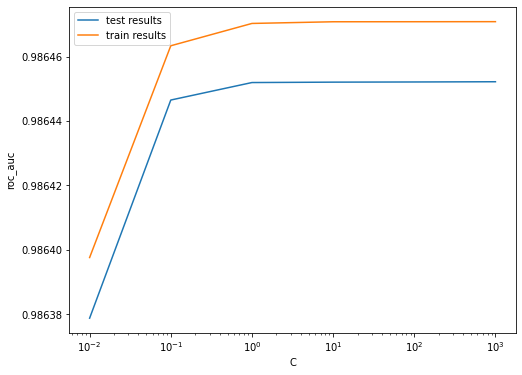

In [41]:
#plot of C versus train and validation score
plt.figure(figsize=(8,6))
plt.plot(log_results['param_C'], log_results['mean_test_score'])
plt.plot(log_results['param_C'],log_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('roc_auc')
plt.legend(['test results','train results'], loc = 'upper left')
plt.xscale('log')

In [42]:
#Best roc_auc with best c
best_score = model_log.best_score_
best_C = model_log.best_params_['C']

print("The highest test roc auc is", best_score, "at C =", best_C)

The highest test roc auc is 0.9864521720568937 at C = 1000


In [43]:
#Logistic Regression with the best C

log_imb = LogisticRegression(C= 1000, random_state= 20, penalty= 'l2')

In [44]:
log_tree_model = log_imb.fit(X_resampled, y_resampled)

*Prediction on test set*

In [45]:
#Prediction on test set
log_pred = log_tree_model.predict(X_test)

In [46]:
#Classification Report
print(classification_report(y_test, log_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     84976
           1       0.05      0.91      0.10       142

    accuracy                           0.97     85118
   macro avg       0.53      0.94      0.54     85118
weighted avg       1.00      0.97      0.98     85118



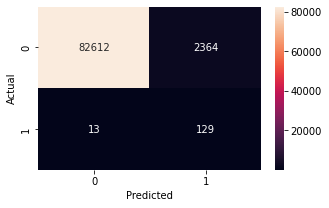

In [47]:
#Confusion Matrix
cm = confusion_matrix(y_test, log_pred)
cm = pd.DataFrame(cm, columns=np.unique(y_test), index= np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(5,3))
sns.heatmap(cm, fmt = 'g', annot= True)

In [48]:
log_confusion = metrics.confusion_matrix(y_test, log_pred)
TP = log_confusion[1,1] # true positive 
TN = log_confusion[0,0] # true negatives
FP = log_confusion[0,1] # false positives
FN = log_confusion[1,0] # false negatives

In [49]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, log_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9720740618905519
Sensitivity:- 0.9084507042253521
Specificity:- 0.972180380342685


In [50]:
#Cross Validate Score
from sklearn.model_selection import cross_val_score
logreg_scores = cross_val_score(log_tree_model, X_resampled, y_resampled, cv = 5)

print("Logisitic Regression Cross Validate Score:", np.round(dt_scores.mean()*100,3), '%')

Logisitic Regression Cross Validate Score: 95.581 %


Plotting ROC

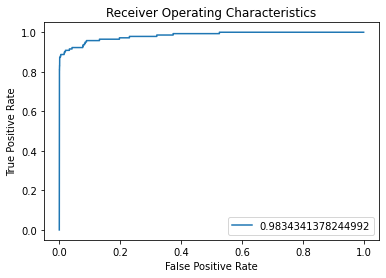

In [51]:
log_proba = log_tree_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, log_proba)
auc = metrics.roc_auc_score(y_test, log_proba)

plt.title('Receiver Operating Characteristics')
plt.plot(fpr, tpr, label = str(auc))
plt.legend(loc = 4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Plotting Precision Recall Curve

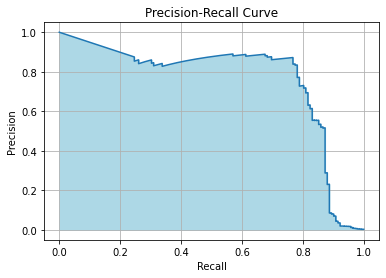

In [52]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, log_proba)
fig, ax = plt.subplots()
ax.plot(recall, precision)

ax.set_title("Precision-Recall Curve")
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.fill_between(recall, precision, color = 'lightblue')
plt.grid()
plt.show()

*XGBoost*

In [53]:
from xgboost import XGBClassifier

Tuning the hyperparameters for XGBoost

In [54]:
#creating a KFold

folds = 5

#specifying the range of the hyperparameters

param_grid2 = {'learning_rate' : [0.2, 0.6],
               'subsample': [0.2, 0.4, 0.6]}

#Specifying the model
xgb_model = XGBClassifier(max_depth= 4, n_estimators= 100, random_state= 20)

model_xgb = GridSearchCV(estimator= xgb_model, param_grid= param_grid2, scoring= 'roc_auc', cv= folds, verbose= 1, return_train_score= True)

model_xgb.fit(X_resampled,y_resampled)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 32.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=20, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.2, 0.4, 0.6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_sco

In [56]:
#XGBoost Results
xgb_results = pd.DataFrame(model_xgb.cv_results_)
xgb_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,54.930920,0.238138,0.339931,0.010720,0.2,0.2,"{'learning_rate': 0.2, 'subsample': 0.2}",0.999986,0.999978,0.999969,0.999983,0.999955,0.999974,0.000011,6,0.999990,0.999989,0.999993,0.999990,0.999989,0.999990,1.458940e-06
1,66.510151,0.598756,0.328463,0.005215,0.2,0.4,"{'learning_rate': 0.2, 'subsample': 0.4}",0.999983,0.999995,0.999985,0.999990,0.999971,0.999985,0.000008,4,0.999993,0.999996,0.999992,0.999990,0.999995,0.999993,2.163429e-06
2,73.869454,0.393752,0.333656,0.005546,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.999976,0.999984,0.999981,0.999981,0.999973,0.999979,0.000004,5,0.999995,0.999993,0.999994,0.999992,0.999995,0.999994,1.116033e-06
3,52.761101,0.273604,0.322821,0.006732,0.6,0.2,"{'learning_rate': 0.6, 'subsample': 0.2}",0.999990,0.999988,0.999992,0.999998,0.999976,0.999989,0.000007,3,1.000000,0.999998,1.000000,1.000000,1.000000,1.000000,7.518836e-07
4,63.957663,0.174981,0.333356,0.011404,0.6,0.4,"{'learning_rate': 0.6, 'subsample': 0.4}",0.999989,1.000000,0.999985,1.000000,0.999977,0.999990,0.000009,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
5,71.468002,0.273605,0.340427,0.003596,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.999999,0.999998,0.999997,1.000000,0.999996,0.999998,0.000001,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00


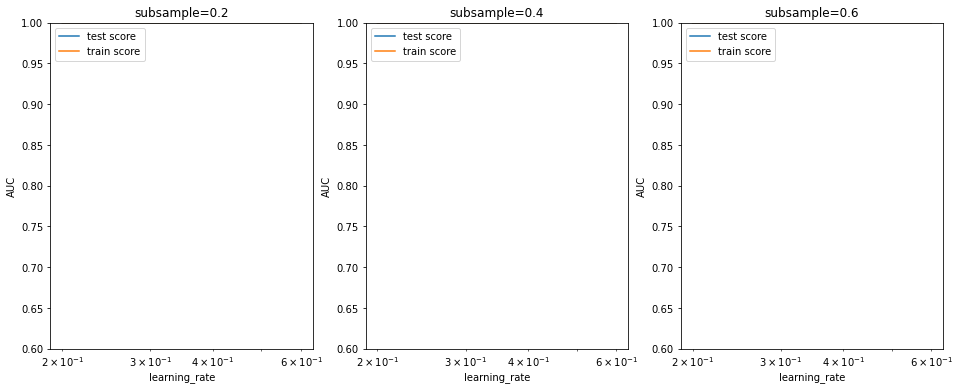

In [57]:
plt.figure(figsize= (16,6))

param_grid3 = {'learning_rate' : [0.2, 0.6],
               'subsample': [0.2, 0.4, 0.6]}

for n , subsample in enumerate (param_grid3['subsample']):
  
  plt.subplot(1,len(param_grid3['subsample']), n+1)
  df = xgb_results[xgb_results['param_subsample']==subsample]
  
  plt.plot(df["param_learning_rate"], df["mean_test_score"])
  plt.plot(df["param_learning_rate"], df["mean_train_score"])
  plt.xlabel('learning_rate')
  plt.ylabel('AUC')
  plt.title("subsample={0}".format(subsample))
  plt.ylim([0.60, 1])
  plt.legend(['test score', 'train score'], loc='upper left')
  plt.xscale('log')

Model with best hyperparameters

From the graph above, we noticed that the train score is almost close to 1 and we noticed that amongest the hyperparameter, the best results are learning_rate: 0.6 and subsample 0.6.

In [58]:
model_xgb.best_params_

{'learning_rate': 0.6, 'subsample': 0.6}

In [59]:
params1 = {'learning_rate': 0.6,
          'max_depth': 4, 
          'n_estimators':100,
          'subsample':0.6,
          'random state' : 20,
         'objective':'binary:logistic'}

xgb_imb = XGBClassifier(params = params1)
xgb_imb.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params={'learning_rate': 0.6, 'max_depth': 4, 'n_estimators': 100,
                      'objective': 'binary:logistic', 'random state': 20,
                      'subsample': 0.6},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

*Prediction on test set*

In [61]:
#Prediction on test set
xgb_pred = xgb_imb.predict(X_test.values)

In [62]:
#Classification Report
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     84976
           1       0.21      0.88      0.33       142

    accuracy                           0.99     85118
   macro avg       0.60      0.94      0.67     85118
weighted avg       1.00      0.99      1.00     85118



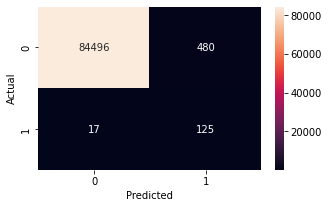

In [63]:
#Confusion Matrix
cm = confusion_matrix(y_test, xgb_pred)
cm = pd.DataFrame(cm, columns=np.unique(y_test), index=np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sns.heatmap(cm, fmt='g', annot = True)

In [64]:
xgb_confusion = metrics.confusion_matrix(y_test, xgb_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [65]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, xgb_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9941610470170822
Sensitivity:- 0.8873239436619719
Specificity:- 0.9633543588778007


In [66]:
#Predicted Probability
xgb_proba = xgb_imb.predict_proba(X_test.values)[:,1]

Plotting ROC

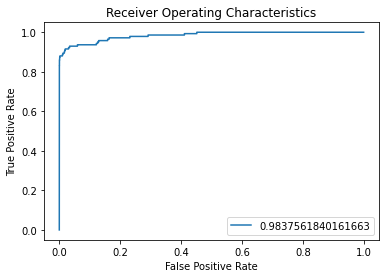

In [67]:
#Plotting ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, xgb_proba)
auc = metrics.roc_auc_score(y_test, xgb_proba)

plt.title('Receiver Operating Characteristics')
plt.plot(fpr, tpr, label = str(auc))
plt.legend(loc = 4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Plotting Preicison-Recall Curve

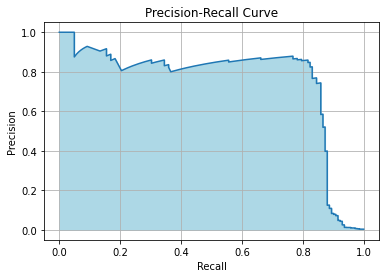

In [68]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, xgb_proba)
fig, ax = plt.subplots()
ax.plot(recall, precision)

ax.set_title("Precision-Recall Curve")
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.fill_between(recall, precision, color = 'lightblue')
plt.grid()
plt.show()